In [2]:
# Cell 1: Load Data  
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans, SpectralClustering  
from sklearn.mixture import GaussianMixture  

OUTPUT_DIR = r"D:\data mining\appendix"  

umap_embeddings = np.load(f'{OUTPUT_DIR}/umap_embeddings.npy')  
true_labels = np.load(f'{OUTPUT_DIR}/true_labels.npy')  

class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']  
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#C7CEEA']  
NUM_CLUSTERS = 6  

print(f"UMAP embeddings: {umap_embeddings.shape}")  
print(f"True labels: {true_labels.shape}")  


UMAP embeddings: (2527, 2)
True labels: (2527,)


In [3]:
print("Applying K-Means...")  

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)  
kmeans_labels = kmeans.fit_predict(umap_embeddings)  

print(f"K-Means complete")  
print(f"Cluster distribution: {np.bincount(kmeans_labels)}")  


Applying K-Means...
K-Means complete
Cluster distribution: [567 592 561 360  51 396]


In [4]:
print("Applying GMM...")  

gmm = GaussianMixture(n_components=NUM_CLUSTERS, random_state=42, covariance_type='full')  
gmm_labels = gmm.fit_predict(umap_embeddings)  

print(f"GMM complete")  
print(f"Cluster distribution: {np.bincount(gmm_labels)}")  


Applying GMM...
GMM complete
Cluster distribution: [903 688 351  51 205 329]


In [5]:

print("Applying Spectral Clustering...")  

spectral = SpectralClustering(n_clusters=NUM_CLUSTERS, random_state=42,  
                             affinity='nearest_neighbors', n_neighbors=10)  
spectral_labels = spectral.fit_predict(umap_embeddings)  

print(f"Spectral Clustering complete")  
print(f"Cluster distribution: {np.bincount(spectral_labels)}")  


Applying Spectral Clustering...


C:\Users\倪晗骏\dml_env\lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Spectral Clustering complete
Cluster distribution: [688 354 285 802  51 347]


In [6]:

# Cell 5: Hungarian Algorithm for Label Alignment  
from scipy.optimize import linear_sum_assignment  

def align_clusters(true_labels, pred_labels):  
    n_clusters = len(np.unique(pred_labels))  
    n_classes = len(np.unique(true_labels))  
    
    confusion = np.zeros((n_clusters, n_classes))  
    for i in range(len(true_labels)):  
        confusion[pred_labels[i], true_labels[i]] += 1  
    
    row_ind, col_ind = linear_sum_assignment(-confusion)  
    mapping = {row: col for row, col in zip(row_ind, col_ind)}  
    aligned_labels = np.array([mapping.get(label, label) for label in pred_labels])  
    
    return aligned_labels, mapping  

kmeans_aligned, kmeans_mapping = align_clusters(true_labels, kmeans_labels)  
gmm_aligned, gmm_mapping = align_clusters(true_labels, gmm_labels)  
spectral_aligned, spectral_mapping = align_clusters(true_labels, spectral_labels)  

print("Label alignment complete")  
print(f"K-Means mapping: {kmeans_mapping}")  
print(f"GMM mapping: {gmm_mapping}")  
print(f"Spectral mapping: {spectral_mapping}")  

Label alignment complete
K-Means mapping: {np.int64(0): np.int64(1), np.int64(1): np.int64(3), np.int64(2): np.int64(0), np.int64(3): np.int64(2), np.int64(4): np.int64(5), np.int64(5): np.int64(4)}
GMM mapping: {np.int64(0): np.int64(1), np.int64(1): np.int64(3), np.int64(2): np.int64(2), np.int64(3): np.int64(5), np.int64(4): np.int64(4), np.int64(5): np.int64(0)}
Spectral mapping: {np.int64(0): np.int64(1), np.int64(1): np.int64(2), np.int64(2): np.int64(4), np.int64(3): np.int64(3), np.int64(4): np.int64(5), np.int64(5): np.int64(0)}


In [7]:

# Cell 6: Clustering Evaluation Metrics  
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score  
import pandas as pd  

clustering_results = {  
    'K-Means': (kmeans_labels, kmeans_aligned),  
    'GMM': (gmm_labels, gmm_aligned),  
    'Spectral': (spectral_labels, spectral_aligned)  
}  

metrics_data = {}  

for method, (pred_labels, aligned) in clustering_results.items():  
    metrics_data[method] = {  
        'ARI': adjusted_rand_score(true_labels, pred_labels),  
        'Silhouette': silhouette_score(umap_embeddings, pred_labels),  
        'Davies-Bouldin': davies_bouldin_score(umap_embeddings, pred_labels),  
        'Accuracy': np.mean(aligned == true_labels)  
    }  

metrics_df = pd.DataFrame(metrics_data).T  

print("\nClustering Performance Metrics:")  
print("="*60)  
print(metrics_df.round(4))  
print("="*60)  

metrics_df.to_csv(f'{OUTPUT_DIR}/clustering_metrics.csv')  



Clustering Performance Metrics:
             ARI  Silhouette  Davies-Bouldin  Accuracy
K-Means   0.3288      0.4929          0.6930    0.5754
GMM       0.3502      0.4147          0.6680    0.5722
Spectral  0.3944      0.4662          0.6426    0.6102


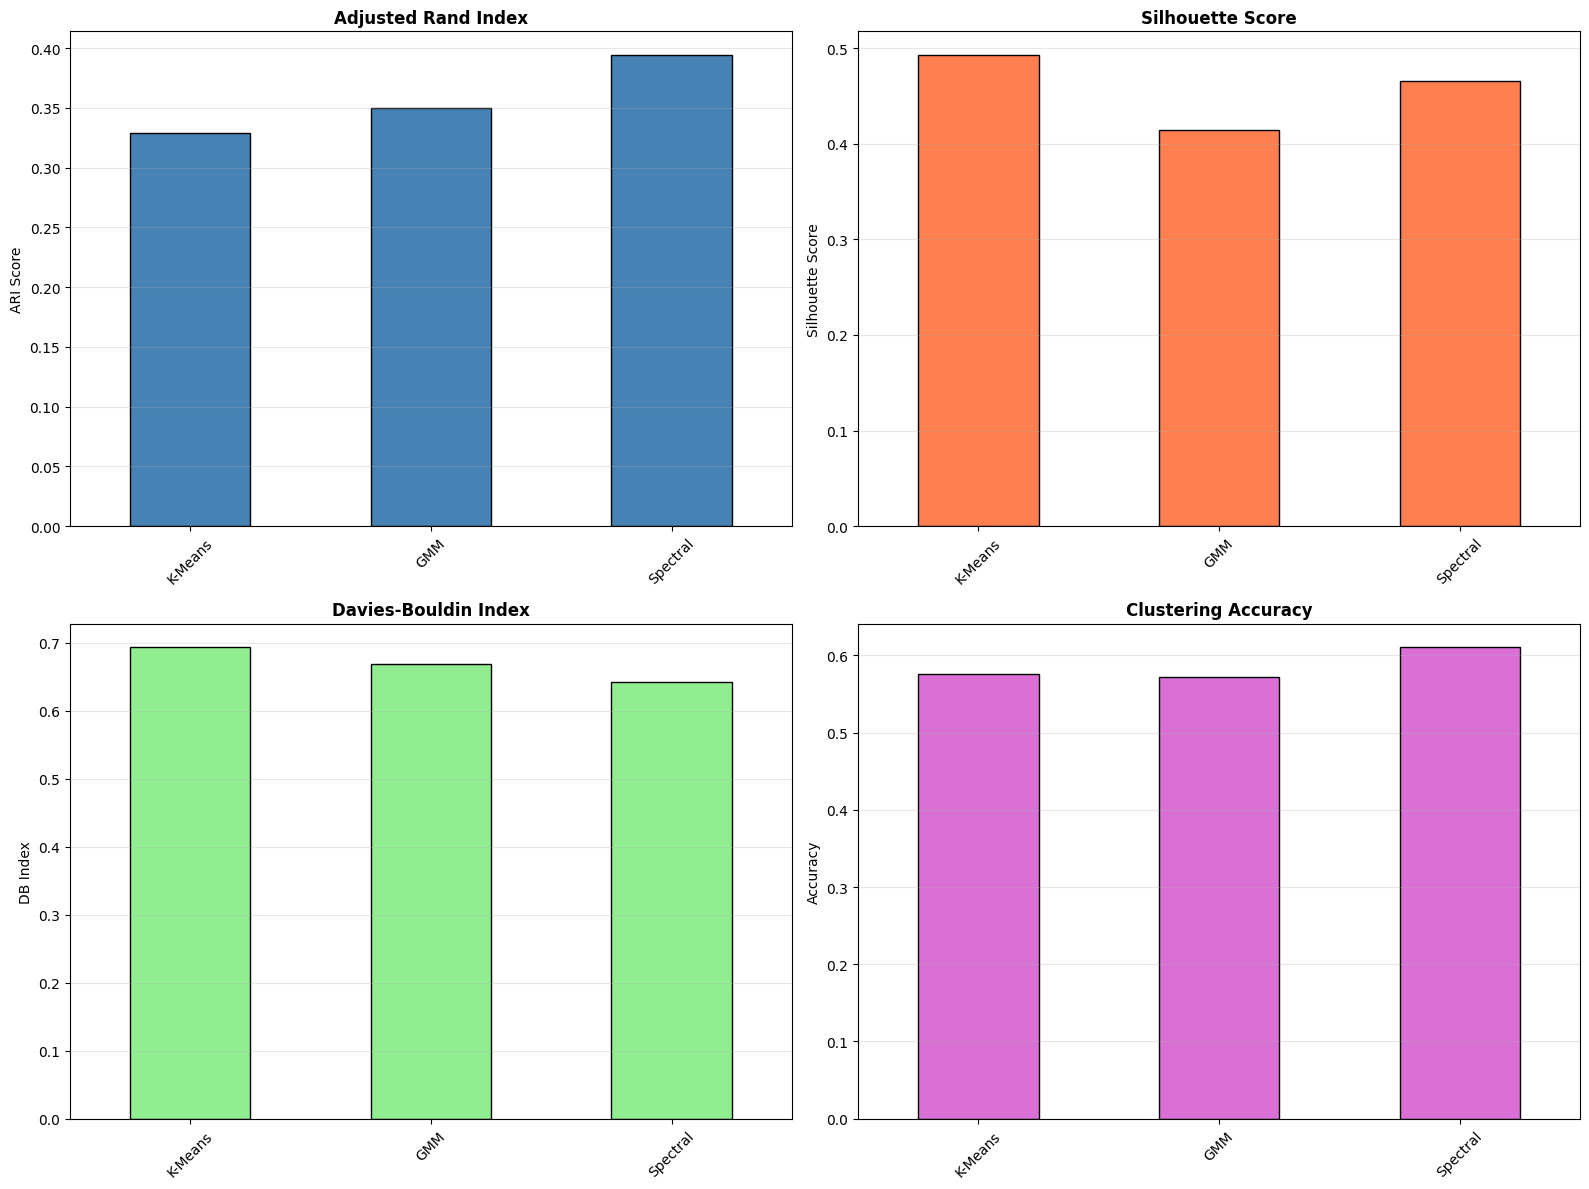

In [8]:

# Cell 7: Metrics Visualization  
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  

metrics_df['ARI'].plot(kind='bar', ax=axes[0, 0], color='steelblue', edgecolor='black')  
axes[0, 0].set_title('Adjusted Rand Index', fontsize=12, fontweight='bold')  
axes[0, 0].set_xticklabels(metrics_df.index, rotation=45)  
axes[0, 0].set_ylabel('ARI Score')  
axes[0, 0].grid(alpha=0.3, axis='y')  

metrics_df['Silhouette'].plot(kind='bar', ax=axes[0, 1], color='coral', edgecolor='black')  
axes[0, 1].set_title('Silhouette Score', fontsize=12, fontweight='bold')  
axes[0, 1].set_xticklabels(metrics_df.index, rotation=45)  
axes[0, 1].set_ylabel('Silhouette Score')  
axes[0, 1].grid(alpha=0.3, axis='y')  

metrics_df['Davies-Bouldin'].plot(kind='bar', ax=axes[1, 0], color='lightgreen', edgecolor='black')  
axes[1, 0].set_title('Davies-Bouldin Index', fontsize=12, fontweight='bold')  
axes[1, 0].set_xticklabels(metrics_df.index, rotation=45)  
axes[1, 0].set_ylabel('DB Index')  
axes[1, 0].grid(alpha=0.3, axis='y')  

metrics_df['Accuracy'].plot(kind='bar', ax=axes[1, 1], color='orchid', edgecolor='black')  
axes[1, 1].set_title('Clustering Accuracy', fontsize=12, fontweight='bold')  
axes[1, 1].set_xticklabels(metrics_df.index, rotation=45)  
axes[1, 1].set_ylabel('Accuracy')  
axes[1, 1].grid(alpha=0.3, axis='y')  

plt.tight_layout()  
plt.savefig(f'{OUTPUT_DIR}/04_clustering_metrics.png', dpi=300, bbox_inches='tight')  
plt.show()  


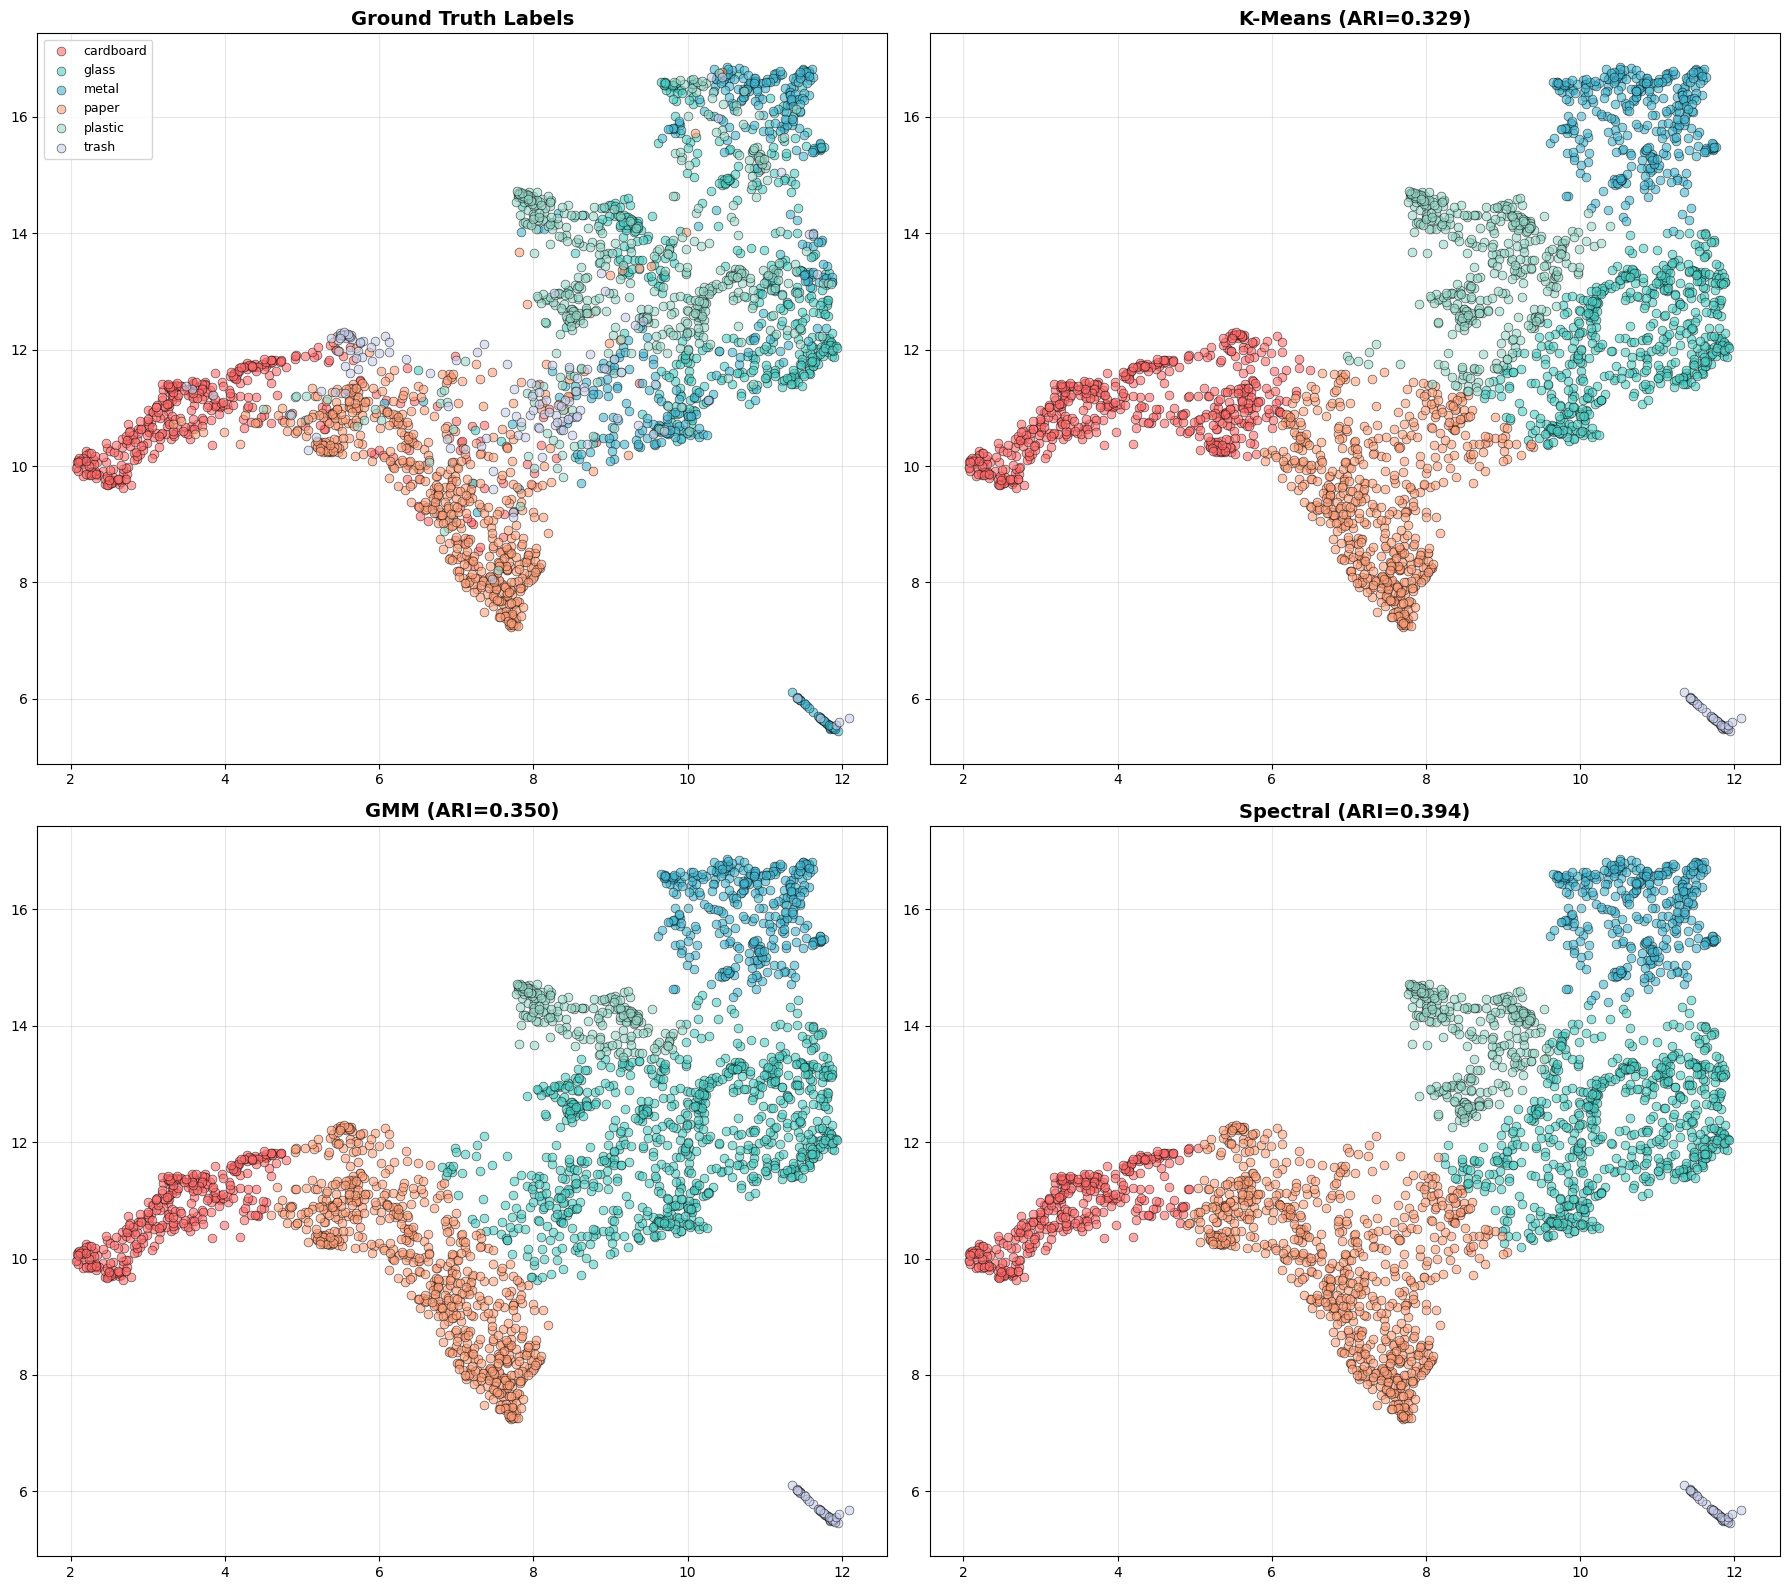

In [9]:

# Cell 8: Clustering Visualization  
fig, axes = plt.subplots(2, 2, figsize=(18, 16))  
axes = axes.flatten()  

# Ground Truth  
for i, (cat, color) in enumerate(zip(class_names, colors)):  
    mask = true_labels == i  
    axes[0].scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],   
                   c=color, label=cat, alpha=0.6, s=40,   
                   edgecolors='black', linewidth=0.5)  
axes[0].set_title('Ground Truth Labels', fontsize=14, fontweight='bold')  
axes[0].legend(fontsize=9)  
axes[0].grid(alpha=0.3)  

# Clustering Results  
methods_list = ['K-Means', 'GMM', 'Spectral']  
for idx, method in enumerate(methods_list, 1):  
    _, aligned = clustering_results[method]  
    
    for i, color in enumerate(colors):  
        mask = aligned == i  
        axes[idx].scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1],   
                        c=color, alpha=0.6, s=40,   
                        edgecolors='black', linewidth=0.5)  
    
    ari = metrics_data[method]['ARI']  
    axes[idx].set_title(f'{method} (ARI={ari:.3f})', fontsize=14, fontweight='bold')  
    axes[idx].grid(alpha=0.3)  

plt.tight_layout()  
plt.savefig(f'{OUTPUT_DIR}/04_clustering_comparison.png', dpi=300, bbox_inches='tight')  
plt.show()  


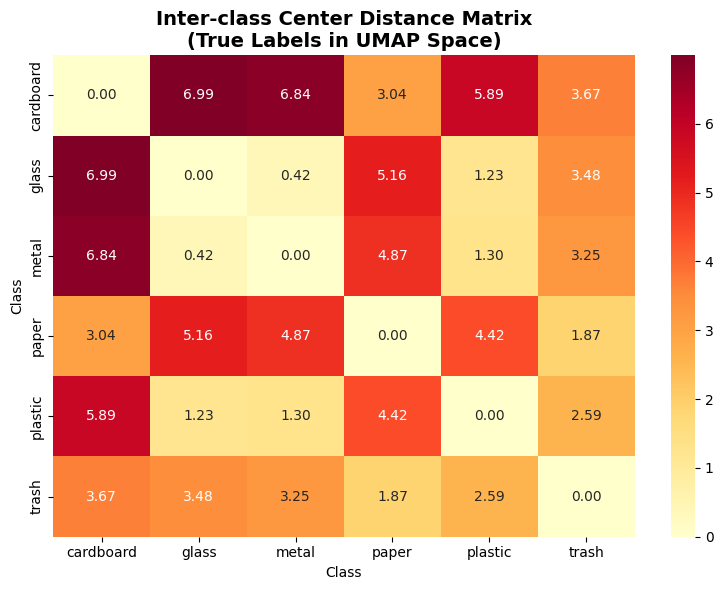

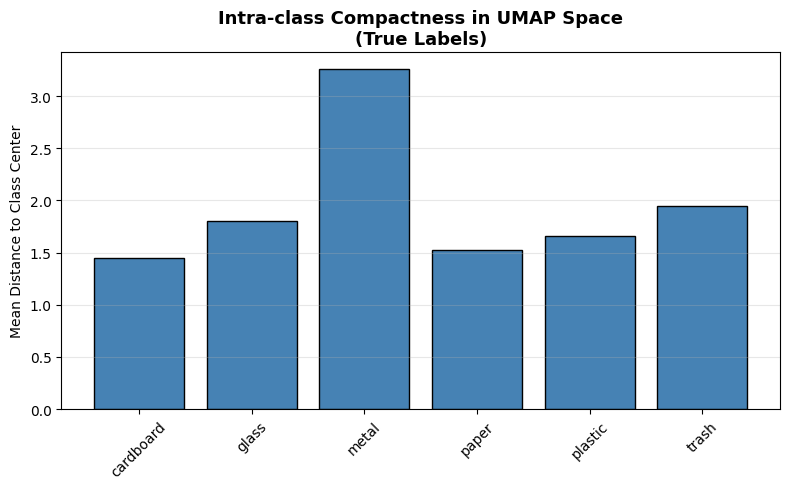

In [10]:
# Cell 9: Class-wise separability using TRUE labels
# -----------------------------------------------
# This cell computes:
#   1) Class centers in the 2D UMAP space
#   2) Pairwise distances between class centers (inter-class separation)
#   3) Mean distance of samples to their class center (intra-class compactness)
# and visualizes them as a heatmap + bar plot.

from scipy.spatial.distance import cdist
import seaborn as sns

def compute_center_stats(embeddings, labels):
    """
    Compute class/cluster centers and intra-class compactness.

    Args:
        embeddings (np.array): 2D UMAP coordinates, shape (n_samples, 2)
        labels (np.array): integer labels, shape (n_samples,)

    Returns:
        centers (np.array): center of each class/cluster, shape (n_classes, 2)
        intra_mean (np.array): mean distance from points to their center, shape (n_classes,)
        dist_matrix (np.array): pairwise center distance matrix, shape (n_classes, n_classes)
        unique_ids (np.array): sorted unique label ids corresponding to rows/cols
    """
    unique_ids = np.unique(labels)
    centers = []
    intra_mean = []

    for cid in unique_ids:
        mask = (labels == cid)
        pts = embeddings[mask]
        center = pts.mean(axis=0)
        centers.append(center)

        # Euclidean distance from each point to its class center
        dists = np.linalg.norm(pts - center, axis=1)
        intra_mean.append(dists.mean())

    centers = np.vstack(centers)
    intra_mean = np.array(intra_mean)
    dist_matrix = cdist(centers, centers)

    return centers, intra_mean, dist_matrix, unique_ids


# --- True-label separability ---
true_centers, true_intra, true_dist_matrix, true_ids = compute_center_stats(
    umap_embeddings, true_labels
)

# Heatmap: inter-class center distances
plt.figure(figsize=(8, 6))
sns.heatmap(
    true_dist_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Inter-class Center Distance Matrix\n(True Labels in UMAP Space)",
          fontsize=14, fontweight="bold")
plt.xlabel("Class")
plt.ylabel("Class")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04_true_class_center_distance.png",
            dpi=300, bbox_inches="tight")
plt.show()

# Bar plot: intra-class compactness
plt.figure(figsize=(8, 5))
plt.bar(class_names, true_intra, color="steelblue", edgecolor="black")
plt.title("Intra-class Compactness in UMAP Space\n(True Labels)",
          fontsize=13, fontweight="bold")
plt.ylabel("Mean Distance to Class Center")
plt.xticks(rotation=45)
plt.grid(alpha=0.3, axis="y")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04_true_class_intra_distance.png",
            dpi=300, bbox_inches="tight")
plt.show()

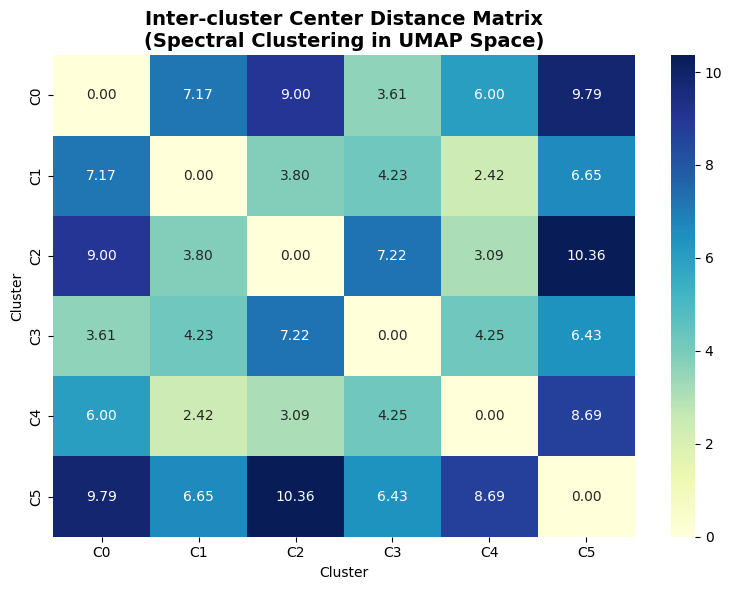

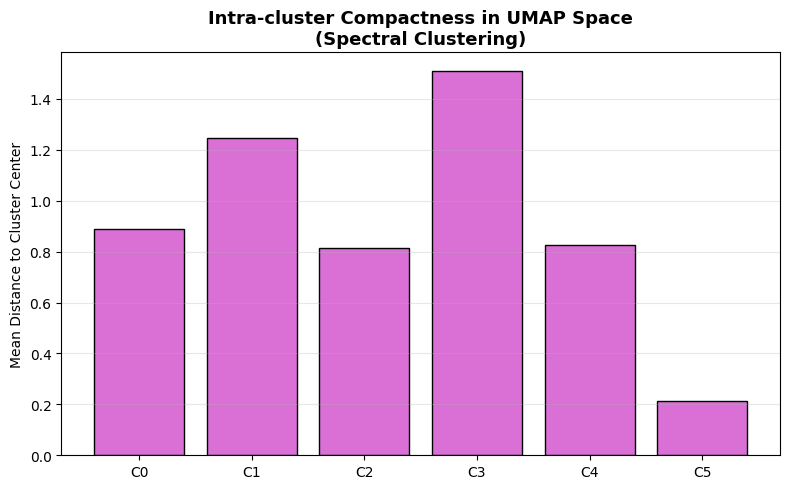

In [11]:
# Cell 10: Cluster-wise separability using SPECTRAL clustering
# ------------------------------------------------------------
# This cell applies the same analysis to the spectral clustering
# assignments (best-performing method), to show how cluster centers
# are positioned in the UMAP space.

# Reuse the helper function `compute_center_stats` from Cell 9

spec_centers, spec_intra, spec_dist_matrix, spec_ids = compute_center_stats(
    umap_embeddings, spectral_aligned
)

cluster_names = [f"C{i}" for i in range(len(spec_ids))]

# Heatmap: inter-cluster center distances (Spectral clusters)
plt.figure(figsize=(8, 6))
sns.heatmap(
    spec_dist_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    xticklabels=cluster_names,
    yticklabels=cluster_names
)
plt.title("Inter-cluster Center Distance Matrix\n(Spectral Clustering in UMAP Space)",
          fontsize=14, fontweight="bold")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04_spectral_cluster_center_distance.png",
            dpi=300, bbox_inches="tight")
plt.show()

# Bar plot: intra-cluster compactness (Spectral)
plt.figure(figsize=(8, 5))
plt.bar(cluster_names, spec_intra, color="orchid", edgecolor="black")
plt.title("Intra-cluster Compactness in UMAP Space\n(Spectral Clustering)",
          fontsize=13, fontweight="bold")
plt.ylabel("Mean Distance to Cluster Center")
plt.grid(alpha=0.3, axis="y")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04_spectral_cluster_intra_distance.png",
            dpi=300, bbox_inches="tight")
plt.show()